# Classifying animals using deep learning

In this notebook we aim to classify different types of animals. We will be using the DuckDuckGo API to scrape sample images off the Web and use these to fine-tune a pretrained convolutional neural network (CNN) to classify the images. This implementation is based on the fast.ai course example [Is it a bird?](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) and Chapter 2 of the fast.ai [`fastbook`](https://github.com/fastai/fastbook).

The 10 animals to classify were chosen by asking ChatGPT to "list 10 animals":

In [5]:
animals = ['lion', 'elephant', 'tiger', 'giraffe', 'bear', 'wolf', 'dolphin',
           'penguin', 'eagle', 'kangaroo']

In [1]:
# The following is a temporary patch to fix a bug with VS Code displaying
# progress bars for Jupyter notebooks
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

## Step 1: Download images of each animal

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In the following code cell, for each of the ten animals we download the first 200 images returned by the DuckDuckGo API. If a folder already exists for an animal, the images of that animal are not re-downloaded.

In [7]:
from fastai.vision.all import *

path = Path('..', 'data', 'animals')

for o in animals:
    dest = (path/o)
    if dest.exists():
        print(f'Data folder for {o} already exists - skipping')
    else:
        dest.mkdir(exist_ok=False, parents=True)
        download_images(dest, urls=search_images(f'{o} animal'))
        resize_images(path/o, max_size=400, dest=path/o)

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

From personal experience, it is a good idea to manually peruse the first few downloaded images for each animal to make sure the results are sensible. This comes after initially searching for "penguin photo" and finding an unruly number of images of the Batman villain.

Fortunately, now having suffixed the search term with "animal", our data set looks reasonable. There are between 75 to 89 images of each animal, which should work well for our classification task.

## Step 2: Train our model

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of the model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

/home/derenteo/git/elec4630/a3/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


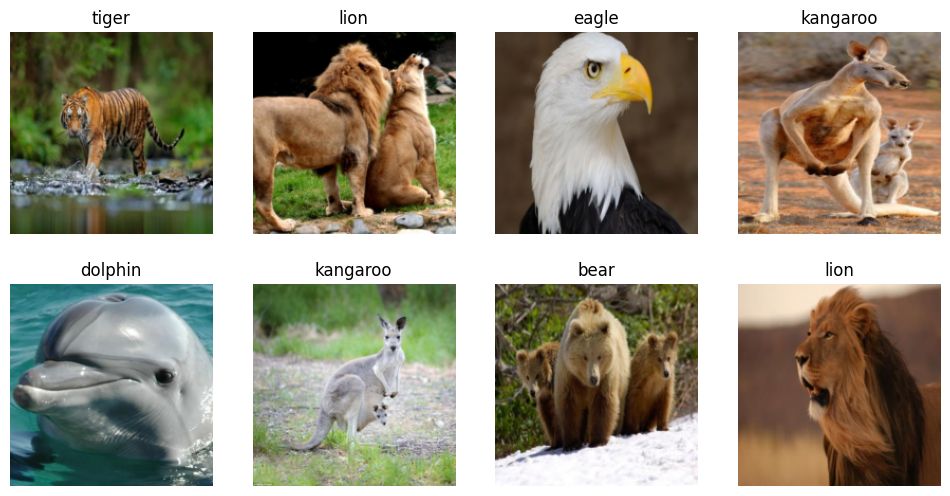

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=8)

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally yakes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

The training and validation losses both decrease with each epoch, as expected. For this particular set of data, after only the first epoch we aready have 100% validation accuracy.

The model is trained by minimising a *loss function*, which is proportional (though not necessarily linearly) to the error in the model. By default, fast.ai selects the [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) function for the vision learner. This is a multi-class loss function with formula (taken from the linked page):

$$\ell(x,y) = L = \{l_1, \ldots, l_N\}^\top,\quad l_n = -w_{y_n}\log\frac{\exp(x_n,y_n)}{\sum_{c=1}^C \exp(x_n,c)}$$

Here, $x$ are the training inputs, $y$ are the training targets, $w$ are the model weights, and $C$ is the number of classes. $N$ is the size of the *minibatch*, which is a subset of the training data. The set of minibatches which covers all training samples exactly once is an epoch<sup>[1](https://www.baeldung.com/cs/epoch-vs-batch-vs-mini-batch)</sup>. Evidently, the loss is exponentially related to each incorrect classification. From above, we can see both the training and validation loss decreasing with each epoch as the model is tuned.

After each training minibatch, the model is evaluated against the validation data and the performance result is described using a metric<sup>[2](https://towardsdatascience.com/whats-the-difference-between-a-metric-and-a-loss-function-38cac955f46d)</sup>. The above fine-tuning uses [`error_rate`](https://docs.fast.ai/metrics.html#error_rate) as the chosen metric. This describes the fraction of incorrectly classified validation images. From above, after the first epoch we already have an error rate of 0%, which indicates 100% validation accuracy. Oh, the wonder of the pre-trained `resnet18` model!

## Step 3: Investigate our results

So, our model managed 100% validation accuracy, but supposing it didn't, we might like to know exactly what misclasifications were made. It could be a case of mislabelled or invalid data. To visualise the (validation set) classification result, we can create a *confusion matrix*:

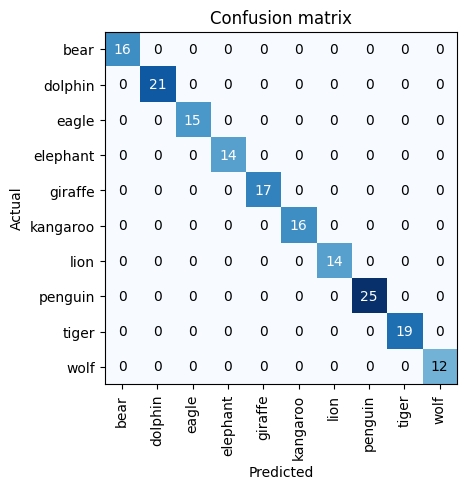

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The columns of the confusion matrix represent the classifications by the model, and the rows represent the true classifications according to our search term. Of course, we would like to maximise the numbers along the diagonal, which represent correct classifications. Our model made no misclassifications, but if it did, these would increment the numbers below the diagonal for each misclassification. For example, if the model labelled a kangaroo as a giraffe, a "1" would appear in the kangaroo row and giraffe column.

If our model had errors, we can see which images caused this by sorting the validation images by their *loss* and displaying the first few:

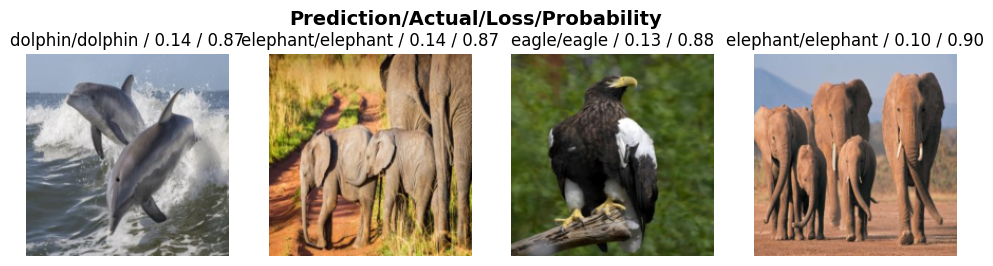

In [11]:
interp.plot_top_losses(4, nrows=1)

The title of the above figure indicates the meaning of the information listed above each image. "Prediction" is the class predicted by the model. "Actual" is the true class, in this case corresponding to the search term which returned the image. "Loss" is a metric describing the error involved in the prediction; given each of the above were correctly classified, the loss is relatively low. "Probability" ranks how likely the model thinks the image matches its predicted classification.

Though the above four images were all classified correctly, it is possible to imagine why these images might have the largest losses. For instance, the dolphin and both elephant images contain multiple animals which partially obscure each other. Meanwhile, the eagle is shown from a low angle and without its wings extended. Each of these is probably not a common representation in the training set.

## Step 4: Visualise the classification

Finally, we can apply *t-SNE* to attempt to visualise how the neural network has separated the various animal classes. t-SNE is an acronym for t-distributed Stochastic Neighbour Embedding, and is a dimensionality reduction technique which aims to preserve relative distances in the high dimensional space when projecting the data into a lower dimension[<sup>3</sup>](https://learnopencv.com/t-sne-for-feature-visualization/). The distance between points in the lower dimensional space is tuned to minimize the difference between the relative distances in the higher dimensional space, with distance measured using [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

To apply t-SNE to visualise our trained model, we have to extract the features learned by the model which directly inform the final classification layer[<sup>3</sup>](https://learnopencv.com/t-sne-for-feature-visualization/). Advice for doing this is provided by user AmorfEvo on a [fast.ai forum post](https://forums.fast.ai/t/feature-extraction-after-fine-tune-from-flatten-layer/102791).

In [18]:
# Cut the model right before the classification layer
# new_head = cut_model(learn.model[-1], 2)
# learn.model[-1] = new_head

# Run data through the new network to derive the feature vectors
x, _ = dls.one_batch()
x.shape

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## References

[1] P. Antoniadis. "Differences between epoch, batch, and mini-batch." (Mar 16, 2023), [Online]. Available: https://www.baeldung.com/cs/epoch-vs-batch-vs-mini-batch

[2] C. Kozyrkov. "What's the difference between a metric and a loss function?" (Jun 18, 2022), [Online]. Available: https://towardsdatascience.com/whats-the-difference-between-a-metric-and-a-loss-function-38cac955f46d

[3] G. Serebryakov. "t-SNE for feature visualization." (Apr 12, 2020), [Online]. Available: https://learnopencv.com/t-sne-for-feature-visualization/